# Info from Kaggle

Data Fields
* PetID - Unique hash ID of pet profile
* AdoptionSpeed - Categorical speed of adoption. Lower is faster. This is the value to predict. See below section for more info.
* Type - Type of animal (1 = Dog, 2 = Cat)
* Name - Name of pet (Empty if not named)
* Age - Age of pet when listed, in months
* Breed1 - Primary breed of pet (Refer to BreedLabels dictionary)
* Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)
* Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
* Color1 - Color 1 of pet (Refer to ColorLabels dictionary)
* Color2 - Color 2 of pet (Refer to ColorLabels dictionary)
* Color3 - Color 3 of pet (Refer to ColorLabels dictionary)
* MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
* FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
* Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
* Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
* Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
* Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
* Quantity - Number of pets represented in profile
* Fee - Adoption fee (0 = Free)
* State - State location in Malaysia (Refer to StateLabels dictionary)
* RescuerID - Unique hash ID of rescuer
* VideoAmt - Total uploaded videos for this pet
* PhotoAmt - Total uploaded photos for this pet
* Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.

AdoptionSpeed

Contestants are required to predict this value. The value is determined by how quickly, if at all, a pet is adopted. The values are determined in the following way:
* 0 - Pet was adopted on the same day as it was listed.
* 1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
* 2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
* 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
* 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

# Setting up the Environment

In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import warnings

import pandas as pd
import numpy as np

from pandas import get_dummies

from sklearn.cluster import DBSCAN
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import silhouette_score

from scipy.spatial.distance import pdist, squareform

from pyclustering.cluster.kmedoids import kmedoids


from scipy.stats import mannwhitneyu

import seaborn as sns
import matplotlib.pyplot as plt

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<IPython.core.display.Javascript object>

# Reading in the Data

In [3]:
breed_labels_df = pd.read_csv("breed_labels.csv")

<IPython.core.display.Javascript object>

In [4]:
breed_labels_df.tail()

,BreedID,Type,BreedName
302,302,2,Torbie
303,303,2,Tortoiseshell
304,304,2,Turkish Angora
305,305,2,Turkish Van
306,306,2,Tuxedo


<IPython.core.display.Javascript object>

In [5]:
color_labels_df = pd.read_csv("color_labels.csv")

<IPython.core.display.Javascript object>

In [6]:
color_labels_df.head(20)

,ColorID,ColorName
0,1,Black
1,2,Brown
2,3,Golden
3,4,Yellow
4,5,Cream
5,6,Gray
6,7,White


<IPython.core.display.Javascript object>

In [7]:
state_labels_df = pd.read_csv("state_labels.csv")

<IPython.core.display.Javascript object>

In [8]:
state_labels_df.head(20)

,StateID,StateName
0,41336,Johor
1,41325,Kedah
2,41367,Kelantan
3,41401,Kuala Lumpur
4,41415,Labuan
5,41324,Melaka
6,41332,Negeri Sembilan
7,41335,Pahang
8,41330,Perak
9,41380,Perlis


<IPython.core.display.Javascript object>

In [9]:
df = pd.read_csv("train/train.csv")

<IPython.core.display.Javascript object>

In [10]:
df.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


<IPython.core.display.Javascript object>

## Missing values

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type           14993 non-null  int64  
 1   Name           13736 non-null  object 
 2   Age            14993 non-null  int64  
 3   Breed1         14993 non-null  int64  
 4   Breed2         14993 non-null  int64  
 5   Gender         14993 non-null  int64  
 6   Color1         14993 non-null  int64  
 7   Color2         14993 non-null  int64  
 8   Color3         14993 non-null  int64  
 9   MaturitySize   14993 non-null  int64  
 10  FurLength      14993 non-null  int64  
 11  Vaccinated     14993 non-null  int64  
 12  Dewormed       14993 non-null  int64  
 13  Sterilized     14993 non-null  int64  
 14  Health         14993 non-null  int64  
 15  Quantity       14993 non-null  int64  
 16  Fee            14993 non-null  int64  
 17  State          14993 non-null  int64  
 18  Rescue

<IPython.core.display.Javascript object>

Looks like `Name` and `Description` have some missingness.  Not too worried about these, so let's deal with them as we come to them.

Now let's go through each of the variables to understand the data better, and get a sense for whether they correlate with our target, `AdoptionSpeed`.

# Data Cleaning and Univariate Analysis

### Type

1 is dog, 2 is cat.  Let's concern ourselves only with cats right now.

In [12]:
df["Type"].value_counts()

1    8132
2    6861
Name: Type, dtype: int64

<IPython.core.display.Javascript object>

Let's make "Type" into a zero or a 1 for convention's sake

In [13]:
df = df[df["Type"] == 2]

<IPython.core.display.Javascript object>

In [14]:
df["Type"].value_counts()

2    6861
Name: Type, dtype: int64

<IPython.core.display.Javascript object>

In [15]:
df = df.drop(columns=["Type"])

<IPython.core.display.Javascript object>

### Quantity

Let's start by subsetting out the cats that aren't in groups.  This means restricting analysis to Quantity == 1

In [16]:
df = df[df["Quantity"] == 1]

<IPython.core.display.Javascript object>

In [248]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4943 entries, 0 to 14991
Data columns (total 59 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              4943 non-null   object 
 1   Age               4943 non-null   int64  
 2   Breed1            4943 non-null   int64  
 3   Breed2            4943 non-null   int64  
 4   Gender            4943 non-null   int64  
 5   Color1            4943 non-null   int64  
 6   Color2            4943 non-null   int64  
 7   Color3            4943 non-null   int64  
 8   MaturitySize      4943 non-null   int64  
 9   FurLength         4943 non-null   int64  
 10  Vaccinated        4943 non-null   int64  
 11  Dewormed          4943 non-null   int64  
 12  Sterilized        4943 non-null   int64  
 13  Health            4943 non-null   int64  
 14  Quantity          4943 non-null   int64  
 15  Fee               4943 non-null   int64  
 16  State             4943 non-null   int64  

<IPython.core.display.Javascript object>

### Name

Missing some names, let's investigate...

Are they MAR?

In [17]:
df[df["Name"].isna().sort_values(ascending=False)]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
5,NaN,3,266,0,2,5,6,0,2,1,...,1,1,0,41326,22fe332bf9c924d4718005891c63fbed,0,This is a stray kitten that came to my house. ...,d24c30b4b,2.0,2
8,NaN,2,265,0,2,6,0,0,2,2,...,1,1,0,41326,d8af7afece71334473575c9f70daf00d,0,"healthy and active, feisty kitten found in nei...",c06d167ca,6.0,1
66,NaN,3,266,0,2,2,0,0,2,1,...,1,1,0,41324,e3bbcf8a10e96c7ec63e557a176c9aa0,0,She needs a loving and caring home...,e540c1ba5,1.0,4
99,NaN,3,265,0,1,1,7,0,2,2,...,1,1,0,41326,c3f6408e1ee043b38bd0d39558b8edf5,0,owner desert them.....,0f24b6cd6,1.0,1
108,NaN,2,266,0,2,6,7,0,2,1,...,1,1,0,41401,abe54643224ddbb5c199cd46fbca0392,0,"10 weeks old cute female kitty, lovable, cuddl...",4407e70f3,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14671,NaN,1,299,299,2,1,2,7,2,1,...,1,1,0,41326,cd2f326ea0852643fe7fe8e97acca5ed,0,My eldest daughter found this little kitten cr...,cce8fa6c2,3.0,2
14709,NaN,4,266,0,2,5,0,0,1,1,...,2,1,0,41326,6612ac86f8e0b9566a4e7e93187f6712,0,this little kitten is found at my apartment ar...,72bb30805,1.0,4
14746,NaN,1,254,266,2,1,2,3,1,1,...,1,1,0,41401,db204da3bd185f11269c3888697c98fd,0,I save this baby cat from the drain.. she is a...,a22a8a017,2.0,4
14794,NaN,4,266,0,1,7,0,0,1,1,...,1,1,0,41336,cda9cadac8f524c705970b4ceccf2e5a,0,"Hi, I've rescued this kitten from our nearby m...",7caa6d216,4.0,4


<IPython.core.display.Javascript object>

What kind of names do we have? First, let's transform this to lowercase so we don't have any issues with string matching...

In [18]:
df["Name"] = df["Name"].str.lower()

df["Name"].value_counts()

kitty                     34
mimi                      32
baby                      30
ginger                    21
no name                   20
                          ..
ginko                      1
boy boy                    1
anak kucing terbiar 05     1
peper                      1
puppy                      1
Name: Name, Length: 3250, dtype: int64

<IPython.core.display.Javascript object>

Looks like we have several "names" that aren't really names (No Name, No Name Yet, Kitty, Kittens, Kitten, Puppy, Puppies, etc.).  We also have some that are null.  

Strategy: Let's make all of these the same "no name" value. 

In [19]:
df["Name"] = df["Name"].fillna("no name")

no_name_list = [
    "kitten",
    "kitty",
    "kitties",
    "kittens",
    "cat",
    "no name",
    "no name yet",
]


names = df["Name"]
no_names = []

for name in names:
    if name in no_name_list:
        no_names.append("no name")
    else:
        no_names.append(name)

df["Name"] = no_names

<IPython.core.display.Javascript object>

In [20]:
has_name = []
names = df["Name"]

for name in names:
    if name == "no name":
        has_name.append(0)
    else:
        has_name.append(1)

has_name = np.array(has_name)
df["has_name"] = has_name
df["has_no_name"] = 1 - has_name

<IPython.core.display.Javascript object>

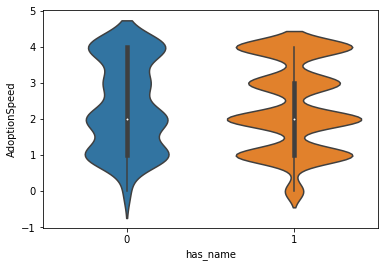

<IPython.core.display.Javascript object>

In [21]:
sns.violinplot(x="has_name", y="AdoptionSpeed", data=df)
plt.show()

TODO: Investigage why are adoption speeds more discretely distributed for animals with names?

### Age

In [22]:
df["Age"].describe()

count    4943.000000
mean        8.237305
std        13.247394
min         0.000000
25%         2.000000
50%         4.000000
75%         9.000000
max       212.000000
Name: Age, dtype: float64

<IPython.core.display.Javascript object>

In [23]:
df["Age"].value_counts().head(24)

2     1007
3      740
1      588
4      489
12     398
5      280
6      275
24     172
7      133
8      122
36      88
10      73
9       71
18      58
11      46
48      43
14      37
0       36
60      26
15      26
17      25
16      19
30      16
13      14
Name: Age, dtype: int64

<IPython.core.display.Javascript object>

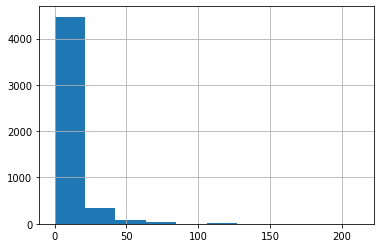

<IPython.core.display.Javascript object>

In [24]:
df["Age"].hist()
plt.show()

Very right-skewed distribution...let's make a new dummy variable called "is_young".  This will be a value of 1 if the animal is less than or equal to two months old, and 0 if the animal is older than two months.

In [25]:
binary_ages = []
ages = df["Age"]

for age in ages:
    if age <= 2:
        binary_ages.append(1)
    else:
        binary_ages.append(0)

binary_ages = np.array(binary_ages)
df["is_young"] = binary_ages
df["is_old"] = 1 - binary_ages

df["is_young"].value_counts()

0    3312
1    1631
Name: is_young, dtype: int64

<IPython.core.display.Javascript object>

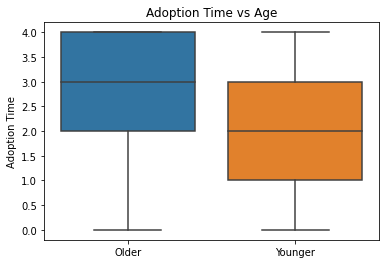

<IPython.core.display.Javascript object>

In [26]:
sns.boxplot("is_young", "AdoptionSpeed", data=df)
plt.ylabel("Adoption Time")
plt.xlabel("")
plt.xticks([0, 1], labels=["Older", "Younger"])
plt.title("Adoption Time vs Age")
# plt.show()
plt.savefig("age_vs_AdoptSpeed.png", dpi=1000)

### Breed1 and Breed2

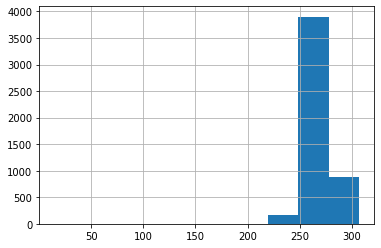

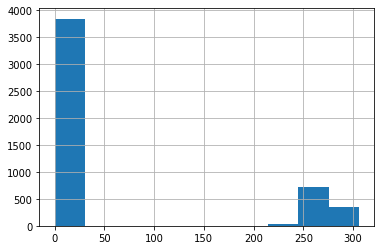

<IPython.core.display.Javascript object>

In [27]:
df["Breed1"].hist()
plt.show()

df["Breed2"].hist()
plt.show()

Because there are so many breeds and major class imbalance, let's simplify and try to create an is_pure_bred feature.  We exclude mixed breed, no breed identified, and generic breeds like domestic short hair.

In [28]:
is_pure_bred = []

breed1 = np.array(df["Breed1"])
breed2 = np.array(df["Breed2"])

excluded_breed_codes = [0, 307, 264, 265, 266]

for i in range(0, len(breed1)):
    if breed1[i] not in excluded_breed_codes and breed2[i] == 0:
        is_pure_bred.append(1)
    else:
        is_pure_bred.append(0)

is_pure_bred = np.array(is_pure_bred)
df["is_pure_bred"] = is_pure_bred
df["is_mixed_breed"] = 1 - is_pure_bred

<IPython.core.display.Javascript object>

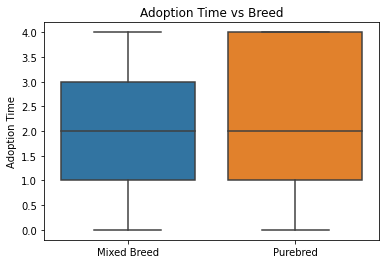

<IPython.core.display.Javascript object>

In [29]:
sns.boxplot("is_pure_bred", "AdoptionSpeed", data=df)
plt.ylabel("Adoption Time")
plt.xlabel("")
plt.xticks([0, 1], labels=["Mixed Breed", "Purebred"])
plt.title("Adoption Time vs Breed")
# plt.show()
plt.savefig("breed_vs_AdoptSpeed.png", dpi=1000)

In [30]:
mixed_df = df[df["is_pure_bred"] == 0]
pure_df = df[df["is_pure_bred"] == 1]
mixed_adoptionspeeds = np.array(mixed_df["AdoptionSpeed"])
pure_adoptionspeeds = np.array(pure_df["AdoptionSpeed"])

_, p = mannwhitneyu(mixed_adoptionspeeds, pure_adoptionspeeds)
p

0.08187205756716293

<IPython.core.display.Javascript object>

### Gender

1 - Male, 2 - Female, 3 - mixed (group of animals).  Let's drop the mixed groups for simplicity, and then encode female as 1 and male as 0.

In [31]:
df["Gender"].value_counts()

2    2662
1    2281
Name: Gender, dtype: int64

<IPython.core.display.Javascript object>

In [32]:
df = df[df["Gender"] != 3]

<IPython.core.display.Javascript object>

In [33]:
df["Gender"].value_counts()

2    2662
1    2281
Name: Gender, dtype: int64

<IPython.core.display.Javascript object>

In [34]:
binary_genders = []
genders = df["Gender"]

for gender in genders:
    if gender == 2:
        binary_genders.append(1)
    else:
        binary_genders.append(0)

binary_genders = np.array(binary_genders)
df["is_female"] = binary_genders
df["is_male"] = 1 - binary_genders

df["is_female"].value_counts()

1    2662
0    2281
Name: is_female, dtype: int64

<IPython.core.display.Javascript object>

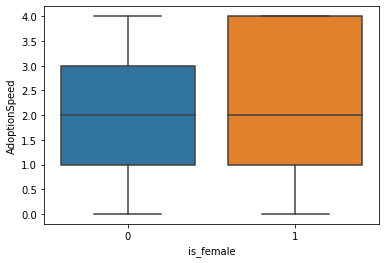

<IPython.core.display.Javascript object>

In [35]:
sns.boxplot(x="is_female", y="AdoptionSpeed", data=df)
plt.show()

### Color1, Color2, and Color3

In [36]:
color_labels_df

,ColorID,ColorName
0,1,Black
1,2,Brown
2,3,Golden
3,4,Yellow
4,5,Cream
5,6,Gray
6,7,White


<IPython.core.display.Javascript object>

In [37]:
print("Color1:")
display(df["Color1"].value_counts())

print("Color2:")
display(df["Color2"].value_counts())

print("Color3:")
display(df["Color3"].value_counts())

Color1:


1    2306
2     816
6     490
3     478
4     363
7     256
5     234
Name: Color1, dtype: int64

Color2:


7    1561
0    1276
2     586
6     568
4     388
5     329
3     235
Name: Color2, dtype: int64

Color3:


0    3417
7    1115
6     167
5     105
4      80
3      59
Name: Color3, dtype: int64

<IPython.core.display.Javascript object>

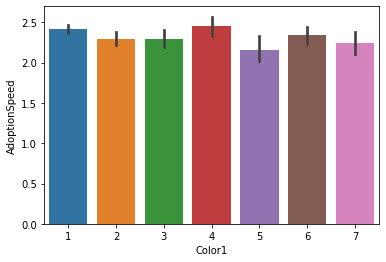

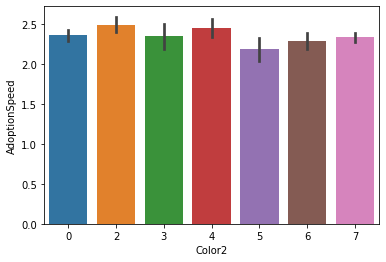

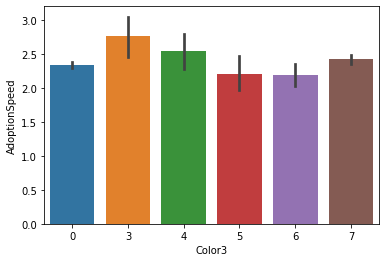

<IPython.core.display.Javascript object>

In [38]:
sns.barplot(x="Color1", y="AdoptionSpeed", data=df)
plt.show()

sns.barplot(x="Color2", y="AdoptionSpeed", data=df)
plt.show()

sns.barplot(x="Color3", y="AdoptionSpeed", data=df)
plt.show()

In [39]:
a = np.array(df["Color1"])
b = np.array(df["Color2"])
c = np.array(df["Color3"])

is_black = [0] * len(a)
is_brown = [0] * len(a)
is_golden = [0] * len(a)
is_yellow = [0] * len(a)
is_cream = [0] * len(a)
is_gray = [0] * len(a)
is_white = [0] * len(a)
is_bicolor = [0] * len(a)
is_multicolor = [0] * len(a)

for i in np.arange(0, len(a)):
    if a[i] == 1:
        is_black[i] = 1
    if a[i] == 2:
        is_brown[i] = 1
    if a[i] == 3:
        is_golden[i] = 1
    if a[i] == 4:
        is_yellow[i] = 1
    if a[i] == 5:
        is_cream[i] = 1
    if a[i] == 6:
        is_gray[i] = 1
    if a[i] == 7:
        is_white[i] = 1
    if b[i] != 0 and c[i] == 0:
        is_bicolor[i] = 1
    if b[i] != 0 and c[i] != 0:
        is_multicolor[i] = 1

df["is_black"] = is_black
df["is_brown"] = is_brown
df["is_golden"] = is_golden
df["is_yellow"] = is_yellow
df["is_cream"] = is_cream
df["is_gray"] = is_gray
df["is_white"] = is_white

is_bicolor = np.array(is_bicolor)
df["is_bicolor"] = is_bicolor
df["is_not_bicolor"] = 1 - is_bicolor

<IPython.core.display.Javascript object>

### MaturitySize

In [40]:
df["MaturitySize"].value_counts()

2    3063
1    1472
3     401
4       7
Name: MaturitySize, dtype: int64

<IPython.core.display.Javascript object>

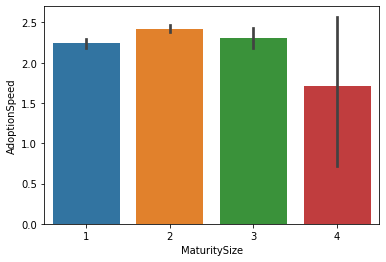

<IPython.core.display.Javascript object>

In [41]:
sns.barplot(x="MaturitySize", y="AdoptionSpeed", data=df)
plt.show()

Combine 4's into threes for a combined large and extra-large category.  Let's also one-hot encode this by hand.  If the animal is medium-sized, then is_medium = 1. If it's large, then is_large = 1. If both are zero, then the animal will be considered small.

In [42]:
is_small = []
is_medium = []
is_large = []
maturity_size = df["MaturitySize"]

for size in maturity_size:
    if size == 4 or size == 3:
        is_small.append(0)
        is_large.append(1)
        is_medium.append(0)
    elif size == 2:
        is_small.append(0)
        is_medium.append(1)
        is_large.append(0)
    elif size == 1:
        is_small.append(1)
        is_medium.append(0)
        is_large.append(0)
    else:
        is_small.append(0)
        is_medium.append(0)
        is_large.append(0)

df["is_small_sized"] = is_small
df["is_medium_sized"] = is_medium
df["is_large_sized"] = is_large

<IPython.core.display.Javascript object>

### FurLength

In [43]:
df["FurLength"].value_counts()

1    2948
2    1636
3     359
Name: FurLength, dtype: int64

<IPython.core.display.Javascript object>

In [44]:
is_short_hair = []
is_medium_hair = []
is_long_hair = []
fur_lengths = df["FurLength"]

for fur in fur_lengths:
    if fur == 1:
        is_short_hair.append(1)
        is_medium_hair.append(0)
        is_long_hair.append(0)
    if fur == 2:
        is_short_hair.append(0)
        is_medium_hair.append(1)
        is_long_hair.append(0)
    if fur == 3:
        is_short_hair.append(0)
        is_medium_hair.append(0)
        is_long_hair.append(1)

df["is_short_hair"] = is_short_hair
df["is_medium_hair"] = is_medium_hair
df["is_long_hair"] = is_long_hair

<IPython.core.display.Javascript object>

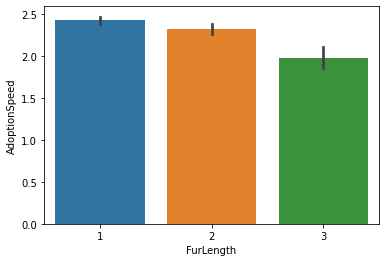

<IPython.core.display.Javascript object>

In [45]:
sns.barplot(x="FurLength", y="AdoptionSpeed", data=df)
plt.show()

### Vaccinated 

In [46]:
df["Vaccinated"].value_counts()

2    2824
1    1611
3     508
Name: Vaccinated, dtype: int64

<IPython.core.display.Javascript object>

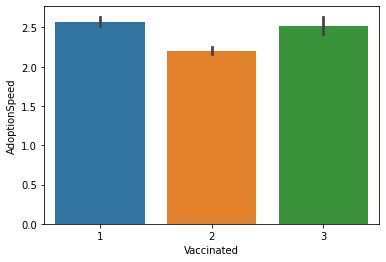

<IPython.core.display.Javascript object>

In [47]:
sns.barplot(x="Vaccinated", y="AdoptionSpeed", data=df)
plt.show()

Suspect this to be collinear with sterilized and dewormed.  

### Dewormed

In [48]:
df["Dewormed"].value_counts()

1    2799
2    1683
3     461
Name: Dewormed, dtype: int64

<IPython.core.display.Javascript object>

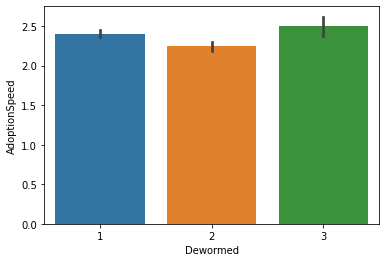

<IPython.core.display.Javascript object>

In [49]:
sns.barplot(x="Dewormed", y="AdoptionSpeed", data=df)
plt.show()

Suspect this to be collinear with sterilized and vaccinated.  

### Sterilized

In [50]:
df["Sterilized"].value_counts()

2    3405
1    1037
3     501
Name: Sterilized, dtype: int64

<IPython.core.display.Javascript object>

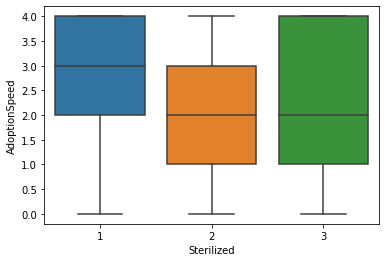

<IPython.core.display.Javascript object>

In [51]:
sns.boxplot(x="Sterilized", y="AdoptionSpeed", data=df)
plt.show()

In [52]:
ster_df = df[df["Sterilized"] == 0]
notster_df = df[df["Sterilized"] == 1]
ster_adoptionspeeds = np.array(ster_df["AdoptionSpeed"])
notster_adoptionspeeds = np.array(notster_df["AdoptionSpeed"])

_, p = mannwhitneyu(ster_adoptionspeeds, notster_adoptionspeeds)
p

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:5700: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


0.0

<IPython.core.display.Javascript object>

Interesting that more are not sterilized than are, but the adoption speed is less for non-sterilized animals, though I'm guessing this a function of age.

#TODO: tease out the relationship between age and sterilized, vaccinated, and dewormed.

Also, the sterilized, vaccinated, and dewormed categories look collinear.  I'm guessing a dog or cat that has been sterilized must have already been dewormed and vaccinated.

In [53]:
is_ster = []
is_not_ster = []
is_maybe_ster = []
sters = df["Sterilized"]

for ster in sters:
    if ster == 1:
        is_ster.append(1)
        is_not_ster.append(0)
        is_maybe_ster.append(0)
    elif ster == 2:
        is_ster.append(0)
        is_not_ster.append(1)
        is_maybe_ster.append(0)
    elif ster == 3:
        is_ster.append(0)
        is_not_ster.append(0)
        is_maybe_ster.append(1)
    else:
        is_ster.append(0)
        is_not_ster.append(0)
        is_maybe_ster.append(0)

df["is_ster"] = is_ster
df["is_not_ster"] = is_not_ster
df["is_maybe_ster"] = is_maybe_ster

<IPython.core.display.Javascript object>

### Health

In [54]:
df["Health"].value_counts()

1    4758
2     172
3      13
Name: Health, dtype: int64

<IPython.core.display.Javascript object>

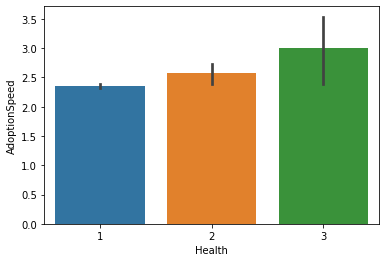

<IPython.core.display.Javascript object>

In [55]:
sns.barplot(x="Health", y="AdoptionSpeed", data=df)
plt.show()

Combining 2s and 3s into an "is_injured" category.

In [56]:
is_injured = []

healths = np.array(df["Health"])

for health in healths:
    if health >= 2:
        is_injured.append(1)
    else:
        is_injured.append(0)

is_injured = np.array(is_injured)
df["is_injured"] = is_injured
df["is_healthy"] = 1 - is_injured

<IPython.core.display.Javascript object>

In [57]:
df["is_injured"].value_counts()

0    4758
1     185
Name: is_injured, dtype: int64

<IPython.core.display.Javascript object>

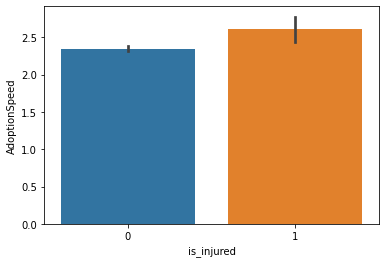

<IPython.core.display.Javascript object>

In [58]:
sns.barplot(x="is_injured", y="AdoptionSpeed", data=df)
plt.show()

### Quantity

In [59]:
df["Quantity"].value_counts()

1    4943
Name: Quantity, dtype: int64

<IPython.core.display.Javascript object>

I'll be restricting my clustering analysis to only individual animals.  See below.

### Fee

In [60]:
df["Fee"].value_counts().head(10)

0      4017
50      241
100     193
150      67
30       65
200      49
10       37
20       33
250      30
1        25
Name: Fee, dtype: int64

<IPython.core.display.Javascript object>

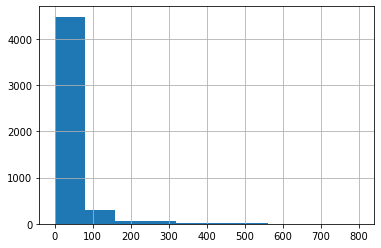

<IPython.core.display.Javascript object>

In [61]:
df["Fee"].hist()
plt.show()

Another very right-skewed distribution...Let's just collapse this down to free and not free.

In [62]:
is_free = []
fees = df["Fee"]

for fee in fees:
    if fee == 0:
        is_free.append(1)
    else:
        is_free.append(0)

is_free = np.array(is_free)
df["is_free"] = is_free
df["is_not_free"] = 1 - is_free
df["is_free"].value_counts()

1    4017
0     926
Name: is_free, dtype: int64

<IPython.core.display.Javascript object>

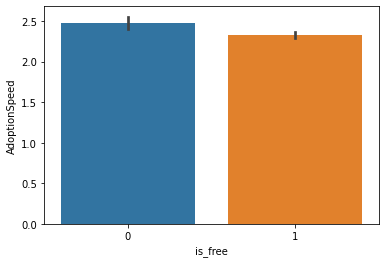

<IPython.core.display.Javascript object>

In [63]:
sns.barplot(x="is_free", y="AdoptionSpeed", data=df)
plt.show()

### State

In [64]:
state_labels_df

,StateID,StateName
0,41336,Johor
1,41325,Kedah
2,41367,Kelantan
3,41401,Kuala Lumpur
4,41415,Labuan
5,41324,Melaka
6,41332,Negeri Sembilan
7,41335,Pahang
8,41330,Perak
9,41380,Perlis


<IPython.core.display.Javascript object>

In [65]:
df["State"].value_counts()

41326    2790
41401    1562
41327     163
41336     144
41332      71
41330      59
41324      39
41325      37
41335      31
41361      20
41345      12
41342       8
41367       7
Name: State, dtype: int64

<IPython.core.display.Javascript object>

In [66]:
is_selangor = []
states = df["State"]

for state in states:
    if state == 41326:
        is_selangor.append(1)
    else:
        is_selangor.append(0)

is_selangor = np.array(is_selangor)
df["is_selangor"] = is_selangor
df["is_not_selangor"] = 1 - is_selangor
df["is_selangor"].value_counts()

1    2790
0    2153
Name: is_selangor, dtype: int64

<IPython.core.display.Javascript object>

### RescuerID

In [67]:
df["RescuerID"].value_counts().head(10)

438a9bdce8ef4d5948fc40e422d34d0d    74
e62135526c27156b8479420aad166317    63
c00756f2bdd8fa88fc9f07a8309f7d5d    62
b770bac0ca797cf1433c48a35d30c4cb    49
167119eeb94dec6c615c602952c527c8    40
90569c3f7cb0af35cba5dac82c0ac9d7    34
09771cded8c18d94a16a6548377410a8    32
95eab75701bfbddafb9e1e01e1ee9214    32
c6fa60201b7ca135608d592d7ac19ec4    30
74dabecce4ddb0c4d08892255974496b    28
Name: RescuerID, dtype: int64

<IPython.core.display.Javascript object>

Creating an "is_top_10_rescue" column that flags whether pet is from a rescue that has some of the most entries.

In [68]:
id_list = list(df["RescuerID"].value_counts().index)
top_10_rescues = id_list[0:10]

rescue_col = df["RescuerID"]
new_rescues_arr = []

for rescue in rescue_col:
    if rescue in top_10_rescues:
        new_rescues_arr.append(1)
    else:
        new_rescues_arr.append(0)

new_rescues_arr = np.array(new_rescues_arr)
df["is_top_10_rescue"] = new_rescues_arr
df["is_small_rescue"] = 1 - new_rescues_arr

<IPython.core.display.Javascript object>

In [69]:
df["is_top_10_rescue"].value_counts().head()

0    4499
1     444
Name: is_top_10_rescue, dtype: int64

<IPython.core.display.Javascript object>

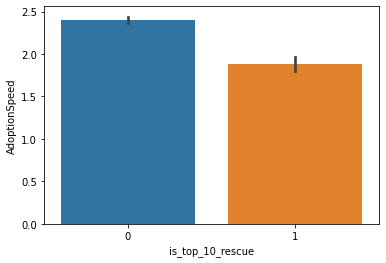

<IPython.core.display.Javascript object>

In [70]:
sns.barplot(x="is_top_10_rescue", y="AdoptionSpeed", data=df)
plt.show()

### VideoAmt

In [71]:
df["VideoAmt"].value_counts().head(20)

0    4740
1     151
2      40
3       6
5       3
6       2
4       1
Name: VideoAmt, dtype: int64

<IPython.core.display.Javascript object>

Let's make this binary, aka has_video: 1-yes, 0-no.

In [72]:
is_videoed = []
video_amts = df["VideoAmt"]
for video_amt in video_amts:
    if video_amt >= 1:
        is_videoed.append(1)
    else:
        is_videoed.append(0)

is_videoed = np.array(is_videoed)
df["is_videoed"] = is_videoed
df["is_not_videoed"] = 1 - is_videoed

<IPython.core.display.Javascript object>

In [73]:
df["is_videoed"].value_counts()

0    4740
1     203
Name: is_videoed, dtype: int64

<IPython.core.display.Javascript object>

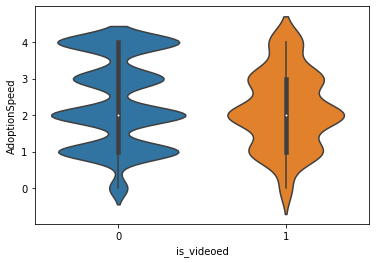

<IPython.core.display.Javascript object>

In [74]:
sns.violinplot(x="is_videoed", y="AdoptionSpeed", data=df)
plt.show()

### Description

In [75]:
df["Description"].value_counts().head()

Cat for adoption                           22
Friendly                                   10
Please feel free to contact us : Stuart     7
Kitten for adoption                         7
LOOKING FOR A FOREVER HOME FOR HER          6
Name: Description, dtype: int64

<IPython.core.display.Javascript object>

Dropping this column altogether.  NLP is beyond the scope of this study.

In [76]:
df = df.drop(columns=["Description"])

<IPython.core.display.Javascript object>

### PetID

In [77]:
df["PetID"].value_counts().head(20)

f10643d7e    1
d40c291a9    1
0907a14f3    1
42e7de7c0    1
9bc084196    1
8a17130c3    1
b68679817    1
160dcaec8    1
e7fbd95a9    1
968c82e07    1
f27974780    1
93a9cf943    1
7238228b5    1
c6a3de42f    1
917ca93b3    1
dfb59bbe9    1
933e0a3e8    1
d69a1f2a1    1
a8cfb849e    1
eab1d3e9f    1
Name: PetID, dtype: int64

<IPython.core.display.Javascript object>

These are unique for each record.  Will drop from dataset and just use a generic index instead...

In [78]:
df = df.drop(columns=["PetID"])

<IPython.core.display.Javascript object>

### PhotoAmt

In [79]:
df["PhotoAmt"].value_counts().head(20)

1.0     963
3.0     891
2.0     818
5.0     748
4.0     639
6.0     212
7.0     155
0.0      87
8.0      83
9.0      70
10.0     65
11.0     55
12.0     35
13.0     27
14.0     20
15.0     16
16.0     11
17.0      8
19.0      7
30.0      5
Name: PhotoAmt, dtype: int64

<IPython.core.display.Javascript object>

Combining all quantities of photos into a has_photo binary.

In [80]:
has_photo = []

photo_amts = df["PhotoAmt"]

for photo_amt in photo_amts:
    if photo_amt == 0:
        has_photo.append(0)
    else:
        has_photo.append(1)

has_photo = np.array(has_photo)
df["has_photo"] = has_photo
df["has_no_photo"] = 1 - has_photo

<IPython.core.display.Javascript object>

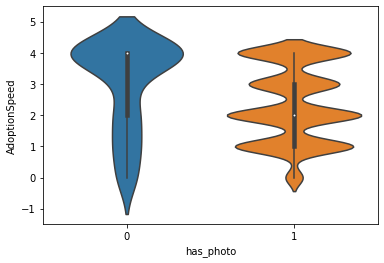

<IPython.core.display.Javascript object>

In [81]:
sns.violinplot(x="has_photo", y="AdoptionSpeed", data=df)
plt.show()

### AdoptionSpeed (Target)

In [82]:
df["AdoptionSpeed"].value_counts()

2    1389
1    1222
4    1212
3     935
0     185
Name: AdoptionSpeed, dtype: int64

<IPython.core.display.Javascript object>

# Clustering

### K-Medoids

In [109]:
# dropping unnecessary or redundant columns
kitty_df = df.drop(
    columns=[
        "Name",
        "Age",
        "Breed1",
        "Breed2",
        "Color2",
        "Color3",
        "MaturitySize",
        "Health",
        "Vaccinated",
        "Dewormed",
        "Quantity",
        "Fee",
        "VideoAmt",
        "PhotoAmt",
        "RescuerID",
        "Gender",
        "Color1",
        "FurLength",
        "Sterilized",
        "State",
    ]
)

# check to make sure it worked...can't be too careful!
kitty_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4943 entries, 0 to 14991
Data columns (total 39 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   AdoptionSpeed     4943 non-null   int64
 1   has_name          4943 non-null   int64
 2   has_no_name       4943 non-null   int64
 3   is_young          4943 non-null   int64
 4   is_old            4943 non-null   int64
 5   is_pure_bred      4943 non-null   int64
 6   is_mixed_breed    4943 non-null   int64
 7   is_female         4943 non-null   int64
 8   is_male           4943 non-null   int64
 9   is_black          4943 non-null   int64
 10  is_brown          4943 non-null   int64
 11  is_golden         4943 non-null   int64
 12  is_yellow         4943 non-null   int64
 13  is_cream          4943 non-null   int64
 14  is_gray           4943 non-null   int64
 15  is_white          4943 non-null   int64
 16  is_bicolor        4943 non-null   int64
 17  is_not_bicolor    4943 non-null 

<IPython.core.display.Javascript object>

In [125]:
binary_df = kitty_df.drop(
    columns=[
        "has_no_name",
        "is_old",
        "is_mixed_breed",
        "is_male",
        "is_black",
        "is_brown",
        "is_golden",
        "is_yellow",
        "is_cream",
        "is_gray",
        "is_white",
        "is_not_bicolor",
        "is_small_sized",
        "is_medium_sized",
        "is_large_sized",
        "is_short_hair",
        "is_medium_hair",
        "is_long_hair",
        "is_ster",
        "is_not_ster",
        "is_maybe_ster",
        "is_healthy",
        "is_not_free",
        "is_not_selangor",
        "is_small_rescue",
        "is_not_videoed",
        "has_no_photo",
    ]
)

<IPython.core.display.Javascript object>

In [126]:
binary_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4943 entries, 0 to 14991
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   AdoptionSpeed     4943 non-null   int64
 1   has_name          4943 non-null   int64
 2   is_young          4943 non-null   int64
 3   is_pure_bred      4943 non-null   int64
 4   is_female         4943 non-null   int64
 5   is_bicolor        4943 non-null   int64
 6   is_injured        4943 non-null   int64
 7   is_free           4943 non-null   int64
 8   is_selangor       4943 non-null   int64
 9   is_top_10_rescue  4943 non-null   int64
 10  is_videoed        4943 non-null   int64
 11  has_photo         4943 non-null   int64
dtypes: int64(12)
memory usage: 662.0 KB


<IPython.core.display.Javascript object>

In [127]:
# X = kitty_df.drop(columns=["AdoptionSpeed"])
X = binary_df.drop(columns=["AdoptionSpeed"])

<IPython.core.display.Javascript object>

In [128]:
dist = pdist(X, metric="hamming")
dist_mat = squareform(dist)
dist_mat.shape

(4943, 4943)

<IPython.core.display.Javascript object>

In [143]:
k = 3
nrows = dist_mat.shape[0]
init_medoids = np.random.randint(0, 2001, k)
init_medoids

array([1791, 1052,  660])

<IPython.core.display.Javascript object>

In [144]:
kmed = kmedoids(
    dist_mat, initial_index_medoids=init_medoids, data_type="distance_matrix"
)

kmed.process()

<IPython.core.display.Javascript object>

In [145]:
medoid_idxs = kmed.get_medoids()
medoid_idxs

[1791, 1052, 8]

<IPython.core.display.Javascript object>

In [146]:
labels = kmed.predict(dist_mat)
labels

array([2, 1, 0, ..., 0, 1, 2])

<IPython.core.display.Javascript object>

In [147]:
kmed_cluster_df = binary_df.copy()
kmed_cluster_df["label"] = labels

<IPython.core.display.Javascript object>

In [148]:
kmed_cluster_df["label"].value_counts()

0    2055
1    1819
2    1069
Name: label, dtype: int64

<IPython.core.display.Javascript object>

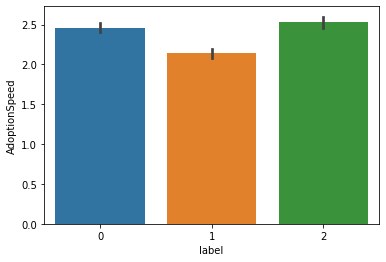

<IPython.core.display.Javascript object>

In [149]:
sns.barplot(x="label", y="AdoptionSpeed", data=kmed_cluster_df)
plt.show()

In [150]:
# plot_cols = kitty_df.columns[:-1]
#
# for col in plot_cols:
#     sns.barplot(x="label", y=col, data=kitty_df)
#     plt.show()

<IPython.core.display.Javascript object>

In [151]:
mean_cluster_df = kmed_cluster_df.groupby("label").mean()
# mean_cluster_df.sort_values("label").style.background_gradient()

<IPython.core.display.Javascript object>

In [152]:
clst_t = mean_cluster_df.T

clst_t_range = clst_t.max(axis=1) - clst_t.min(axis=1)
clst_t_sd = clst_t.std(axis=1)

clst_t["range"] = clst_t_range
clst_t["sd"] = clst_t_sd
clst_t.sort_values("range", ascending=False).style.background_gradient(axis=1)

label,0,1,2,range,sd
is_bicolor,0.207786,0.354590,1.000000,0.792214,0.421448
is_young,0.146472,0.731171,0.000000,0.731171,0.386854
is_female,0.841849,0.331501,0.307764,0.534085,0.301735
AdoptionSpeed,2.460827,2.140187,2.528531,0.388344,0.207447
is_selangor,0.767883,0.439802,0.385407,0.382476,0.206916
is_top_10_rescue,0.044282,0.152281,0.071094,0.107999,0.056235
has_name,0.963504,0.865860,0.945744,0.097643,0.052011
is_videoed,0.021411,0.069269,0.030870,0.047858,0.025345
is_pure_bred,0.127007,0.146234,0.166511,0.039503,0.019754
is_injured,0.018005,0.057174,0.041160,0.039169,0.019693


<IPython.core.display.Javascript object>

In [217]:
sscore = silhouette_score(dist_mat, labels, metric="precomputed")
sscore

0.19595020836191343

<IPython.core.display.Javascript object>

The silhouette score is pretty bad, but that might not be the best evaluation of the clustering.  Let's try some other methods of clustering to compare.

### DBSCAN

In [237]:
# Defining the agglomerative clustering
dbscan_cluster = DBSCAN(eps=0.11, min_samples=12, metric="precomputed")

# Fit model
clusters = dbscan_cluster.fit_predict(dist_mat)

<IPython.core.display.Javascript object>

In [238]:
b = np.unique(dbscan_cluster.labels_)
b

array([-1,  0])

<IPython.core.display.Javascript object>

In [239]:
print(
    "The silhouette score of the DBSCAN solution: {}".format(
        silhouette_score(dist_mat, clusters, metric="precomputed")
    )
)

The silhouette score of the DBSCAN solution: 0.41688341004240126


<IPython.core.display.Javascript object>

The silhouette score is better here, but we're only getting one cluster and some outliers.  Even with fiddling around with epsilon and min_samples, there is no combination of those that produce sensible clustering results.  I'm guessing the points aren't easily separable.

Let's try one more method.

### Affinity Propagation

In [240]:
clst = AffinityPropagation(affinity="precomputed", damping=0.999, verbose=1)
clst.fit(dist_mat)

Converged after 88 iterations.


AffinityPropagation(affinity='precomputed', convergence_iter=15, copy=True,
                    damping=0.999, max_iter=200, preference=None, verbose=1)

<IPython.core.display.Javascript object>

In [241]:
b = np.unique(clst.labels_)
b

array([0, 1, 2])

<IPython.core.display.Javascript object>

In [242]:
ap_cluster_df = binary_df.copy()
ap_cluster_df["label"] = clst.labels_
ap_cluster_df["label"] = "Cluster " + ap_cluster_df["label"].astype(str)

<IPython.core.display.Javascript object>

In [243]:
cluster_sizes = ap_cluster_df["label"].value_counts().reset_index()
cluster_sizes.columns = ["label", "count"]

<IPython.core.display.Javascript object>

In [259]:
cluster_sizes

,label,count
0,Cluster 0,2124
1,Cluster 1,1875
2,Cluster 2,944


<IPython.core.display.Javascript object>

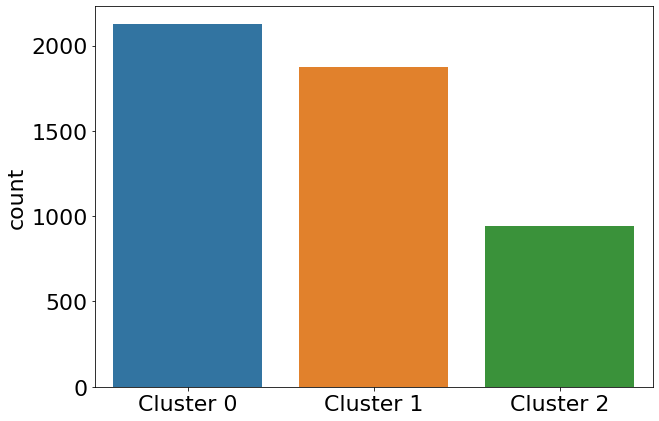

<IPython.core.display.Javascript object>

In [268]:
plt.figure(figsize=(10, 7))
sns.barplot(x="label", y="count", data=cluster_sizes)
plt.xlabel("")
plt.show()

In [244]:
exemplar_idxs = clst.cluster_centers_indices_
exemplars = ap_cluster_df.iloc[exemplar_idxs, :]

exemplars = pd.merge(exemplars, cluster_sizes, on="label")

# Threshold to be displayed
thresh = 40
display_exemplars = exemplars[exemplars["count"] >= thresh]

large_cluster_labels = display_exemplars["label"]

display_exemplars.sort_values("label").style.background_gradient()

,AdoptionSpeed,has_name,is_young,is_pure_bred,is_female,is_bicolor,is_injured,is_free,is_selangor,is_top_10_rescue,is_videoed,has_photo,label,count
0,2,1,1,1,1,1,0,0,1,1,1,1,Cluster 0,2124
1,2,1,1,1,1,0,0,0,1,1,1,1,Cluster 1,1875
2,4,1,0,1,1,1,0,0,0,0,0,0,Cluster 2,944


<IPython.core.display.Javascript object>

In [245]:
large_cluster_df = ap_cluster_df[ap_cluster_df["label"].isin(large_cluster_labels)]
mean_cluster_df = large_cluster_df.groupby("label").mean()
mean_cluster_df.sort_values("label").style.background_gradient()

,AdoptionSpeed,has_name,is_young,is_pure_bred,is_female,is_bicolor,is_injured,is_free,is_selangor,is_top_10_rescue,is_videoed,has_photo
label,,,,,,,,,,,,
Cluster 0,2.520716,0.925141,0.139360,0.166196,0.601224,0.000471,0.036252,0.821563,0.458569,0.026365,0.013653,0.970339
Cluster 1,2.393067,0.926400,0.273600,0.137067,0.462933,0.999467,0.041600,0.835200,0.498667,0.058133,0.022933,0.987733
Cluster 2,1.919492,0.915254,0.870763,0.100636,0.547669,0.281780,0.031780,0.747881,0.933263,0.295551,0.138771,0.998941


<IPython.core.display.Javascript object>

In [246]:
clst_t = mean_cluster_df.T

clst_t_range = clst_t.max(axis=1) - clst_t.min(axis=1)
clst_t_sd = clst_t.std(axis=1)

clst_t["range"] = clst_t_range
clst_t["sd"] = clst_t_sd
clst_t.sort_values("range", ascending=False).style.background_gradient(axis=1)

label,Cluster 0,Cluster 1,Cluster 2,range,sd
is_bicolor,0.000471,0.999467,0.281780,0.998996,0.515138
is_young,0.139360,0.273600,0.870763,0.731403,0.389353
AdoptionSpeed,2.520716,2.393067,1.919492,0.601224,0.316764
is_selangor,0.458569,0.498667,0.933263,0.474694,0.263254
is_top_10_rescue,0.026365,0.058133,0.295551,0.269185,0.147104
is_female,0.601224,0.462933,0.547669,0.138291,0.069729
is_videoed,0.013653,0.022933,0.138771,0.125118,0.069712
is_free,0.821563,0.835200,0.747881,0.087319,0.046974
is_pure_bred,0.166196,0.137067,0.100636,0.065560,0.032848
has_photo,0.970339,0.987733,0.998941,0.028602,0.014412


<IPython.core.display.Javascript object>

In [247]:
sscore = silhouette_score(dist_mat, clst.labels_, metric="precomputed")
sscore

0.253188473922401

<IPython.core.display.Javascript object>

This is a slightly better result than the previous two clustering methods.  Choosing 3 clusters produced the most differentiated clusters.

# Plotting Results

The goal is to find the characteristics that are governing the adoption time.  Let's find out whether adoption times vary between clusters, and then characterize the clusters.

In [262]:
ap_cluster_df = ap_cluster_df.sort_values("label")

<IPython.core.display.Javascript object>

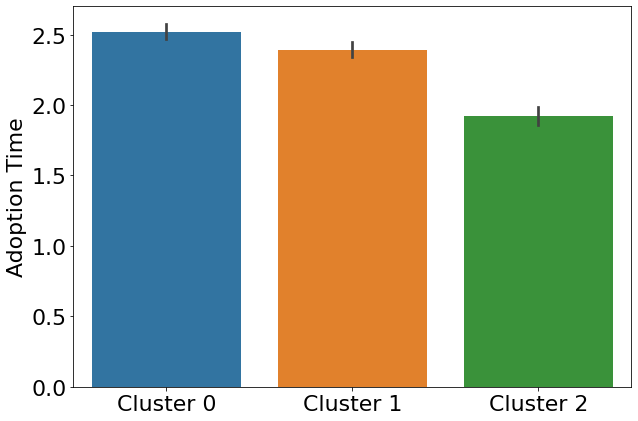

<IPython.core.display.Javascript object>

In [277]:
font = {"family": "normal", "weight": "normal", "size": 22}

plt.rc("font", **font)

plt.figure(figsize=(10, 7))
sns.barplot(x="label", y="AdoptionSpeed", data=ap_cluster_df)
plt.xlabel("")
plt.ylabel("Adoption Time")
plt.show()

Cluster 2 has the shortest adoption time and Cluster 0 has the longest.  Let's see what the other characteristics of the clusters are...

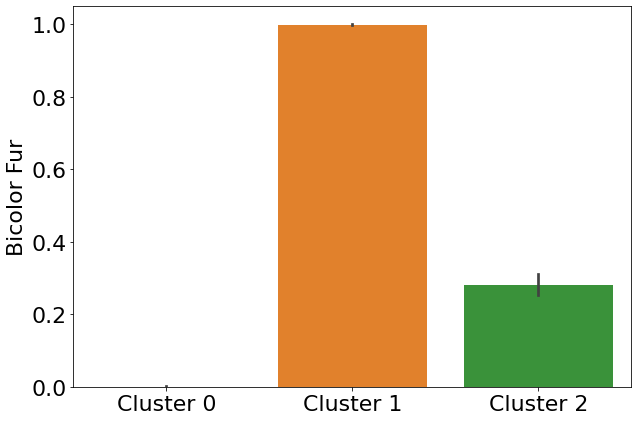

<IPython.core.display.Javascript object>

In [271]:
plt.figure(figsize=(10, 7))
sns.barplot(x="label", y="is_bicolor", data=ap_cluster_df)
plt.xlabel("")
plt.ylabel("Bicolor Fur")
plt.show()

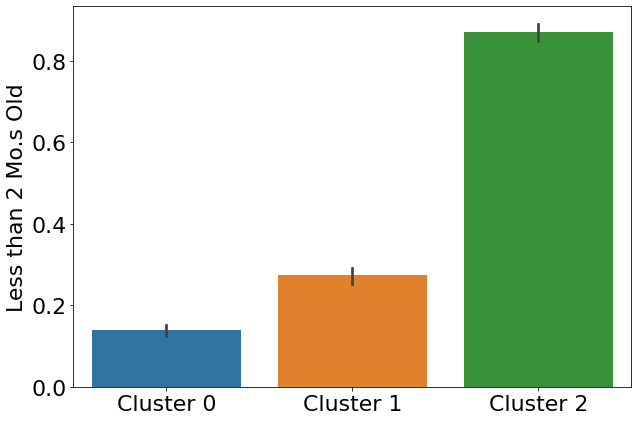

<IPython.core.display.Javascript object>

In [273]:
plt.figure(figsize=(10, 7))
sns.barplot(x="label", y="is_young", data=ap_cluster_df)
plt.xlabel("")
plt.ylabel("Less than 2 Mo.s Old")
plt.show()

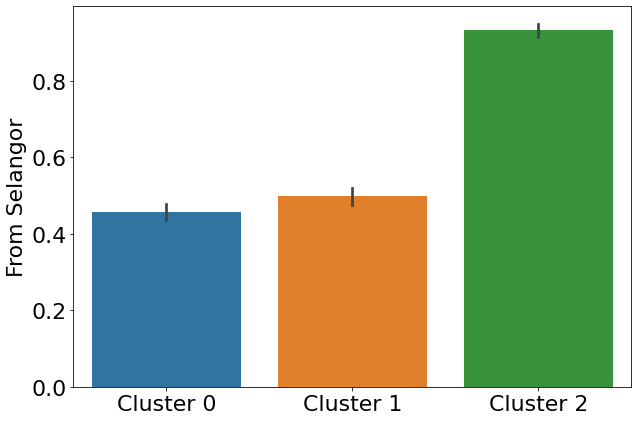

<IPython.core.display.Javascript object>

In [274]:
plt.figure(figsize=(10, 7))
sns.barplot(x="label", y="is_selangor", data=ap_cluster_df)
plt.xlabel("")
plt.ylabel("From Selangor")
plt.show()

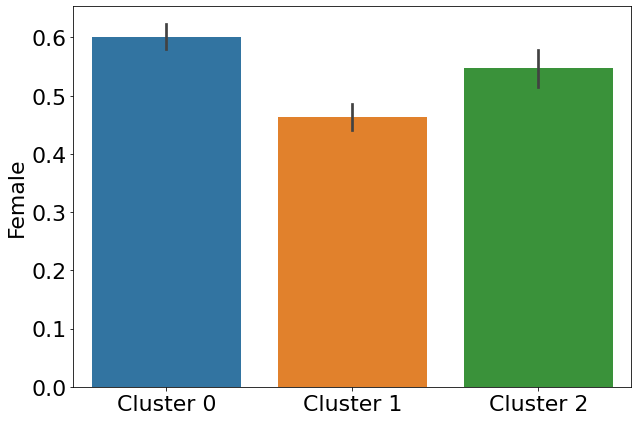

<IPython.core.display.Javascript object>

In [275]:
plt.figure(figsize=(10, 7))
sns.barplot(x="label", y="is_female", data=ap_cluster_df)
plt.xlabel("")
plt.ylabel("Female")
plt.show()

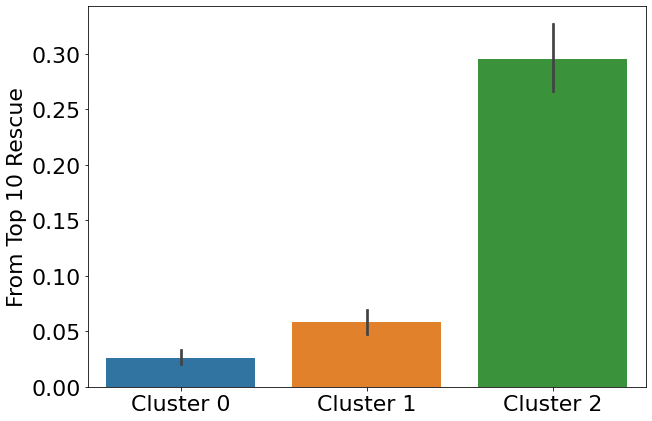

<IPython.core.display.Javascript object>

In [276]:
plt.figure(figsize=(10, 7))
sns.barplot(x="label", y="is_top_10_rescue", data=ap_cluster_df)
plt.xlabel("")
plt.ylabel("From Top 10 Rescue")
plt.show()

# Conclusions

It looks like the shorter adoption times are from the cluster that is most often from the top ten most popular rescues and the most populous region in Malaysia, and they tend to be younger than the other clusters.

The longest adoption times are associated with older, female, and monocolor.

# (Possible) Actionable Insights

Rescuers can devote more advertising resources to older animals from more rural parts of Malaysia.

Concientious adopters can be more aware that adopting older, mono-color, female animals will have a larger impact on animal welfare. 